In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

%load_ext autoreload
%autoreload 2

os.chdir('/content/drive/MyDrive/PR_202210835/Lab04')

Mounted at /content/drive


In [2]:
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt

- 입력 영상은 Gray Scale로 일기
1. 입력 영상을 가우시안 스무딩
2. 결과 영상에 소벨 연산자를 적용하여 에지 강도와 방향 맵 구하기
3. 비최대 억제를 적용하여 얇은 두께 에지 맵 생성
4. 임계값(threshold)을 적용하여 거짓 긍정 제거

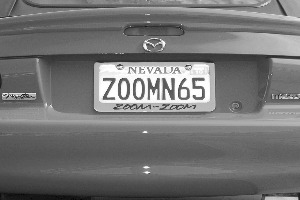

In [3]:
## 0. 입력 Gray scale로 읽기

image = cv2.imread('images/car01.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (300,200))
cv2_imshow(image)

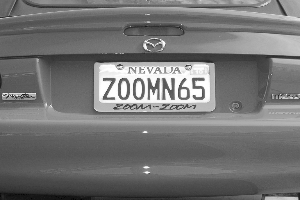

In [4]:
## 1. 가우시안 스무딩

gaus_img = cv2.GaussianBlur(image, (5,5), 0.3)
cv2_imshow(gaus_img)

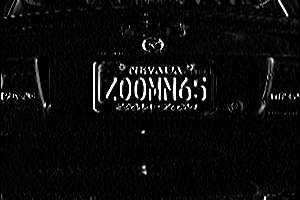

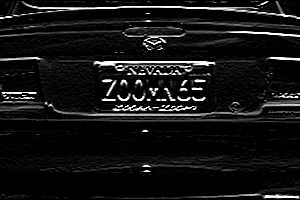

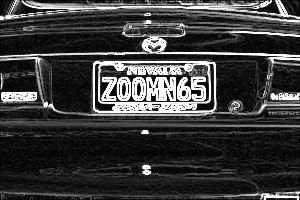

In [5]:
## 2. 결과 영상에 소벨 연산자를 적용하여 에지 강도와 방향 맵 구하기

Gx = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 1, 0, 3) # x뱡향 마스크
Gy = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 0, 1, 3) # y방향 마스크
sobel = np.fabs(Gx) + np.fabs(Gy) # 두 행렬 절댓값 덧셈

cv2_imshow(Gx)
cv2_imshow(Gy)
cv2_imshow(sobel)

In [14]:
# 그래디언트 벡터의 방향     //각도를 8방향으로 나눔
directs = cv2.phase(Gx, Gy) / (np.pi/4) #  각도, 방향
directs = directs.astype(int) % 4
directs

array([[0, 2, 2, ..., 0, 2, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [3, 2, 2, ..., 3, 3, 1],
       ...,
       [1, 3, 3, ..., 1, 1, 1],
       [3, 3, 3, ..., 1, 1, 1],
       [0, 0, 0, ..., 2, 2, 0]])

In [8]:
# # 그래디언트 벡터의 방향     //각도를 8방향으로 나눔
# directs = cv2.phase(Gx, Gy) / (np.pi/4) #  각도, 방향
# directs

array([[0.       , 4.       , 4.       , ..., 0.       , 4.       ,
        0.       ],
       [2.       , 2.4097483, 3.4843817, ..., 0.       , 2.1408753,
        2.       ],
       [6.       , 5.3119984, 4.4675984, ..., 7.1726837, 7.590251 ,
        2.       ],
       ...,
       [2.       , 7.9825625, 7.359774 , ..., 2.904624 , 3.4236217,
        2.       ],
       [6.       , 7.6055975, 7.3016615, ..., 3.6820617, 3.7863715,
        2.       ],
       [0.       , 0.       , 0.       , ..., 4.       , 4.       ,
        0.       ]], dtype=float32)

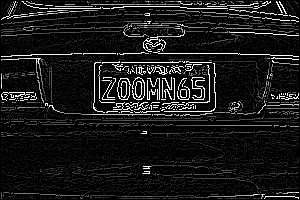

In [ ]:
## 3. 비최대 억제를 적용하여 얇은 두께 에지 맵 생성

def non_max_suppression(sobel, directs): # 비최대치 억제 함수
    rows, cols = sobel.shape [:2]
    dst = np.zeros((rows, cols), np.float32)
    for i in range(1, rows-1):
        for j in range(1, cols-1): # 행렬처리를 통해 이웃 화소 가져오기
          values = sobel[i-1:i+2, j-1:j+2].flatten()
          first = [3, 0, 1, 2]
          id = first[directs[i, j]]
          v1, v2 = values[id], values[8-id]
          dst[i, j] = sobel[i, j] if (v1 < sobel[i, j] > v2) else 0

    return dst

max_sobel = non_max_suppression(sobel, directs) # 비최대치 억제
cv2_imshow(max_sobel)

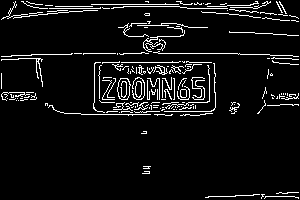

In [ ]:
## 4. 임계값(threshold)을 적용하여 거짓 긍정 제거

def trace(max_sobel, i, j, low, pos_ck, canny) :
  h,w = max_sobel.shape
  if (0 <= i < h and 0 <= j < w) == False : return # 추적화소 범위 확인
  if pos_ck[i, j] == 0 and max_sobel[i, j] >= low : # 추적화소가 아닌 경우
    pos_ck[i, j] = 255
    canny[i, j] = 255

    trace(max_sobel, i-1, j-1, low, pos_ck, canny)
    trace(max_sobel, i, j-1, low, pos_ck, canny)
    trace(max_sobel, i+1, j-1, low, pos_ck, canny)
    trace(max_sobel, i-1, j, low, pos_ck, canny)
    trace(max_sobel, i+1, j, low, pos_ck, canny)
    trace(max_sobel, i-1, j+1, low, pos_ck, canny)
    trace(max_sobel, i, j+1, low, pos_ck, canny)
    trace(max_sobel, i+1, j+1, low, pos_ck, canny)

def hysteresis_th(max_sobel, low, high) : # 이력 임계값 수행
  pos_ck = np.zeros(max_sobel.shape[:2], np.uint8)
  canny = np.zeros(max_sobel.shape[:2], np.uint8)

  rows, cols = max_sobel.shape[:2]
  for i in range(1, rows-1) : # 에지 영상 순회
    for j in range(1, cols-1) :
      if max_sobel[i,j] > high : trace(max_sobel, i, j, low, pos_ck, canny) # 추적 시작

  return canny

canny = hysteresis_th(max_sobel, 100, 200) # 이력 임계
cv2_imshow(canny)

In [ ]:
## CNN 모델로 Canny Edge Detection 구현해보기

import tensorflow as tf
import numpy as np
import cv2

#MNIST 데이터셋 로드
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0 # 이미지 정규화

# Canny edge detection 적용 함수
def apply_canny_edge_detection(images):
    edge_images = []
    for img in images:
        edge_img= cv2.Canny((img * 255).astype(np.uint8), 100, 200) # Canny edge 적용
        edge_images.append(edge_img)
    return np.array(edge_images)

# 채널 차원 추가
X_train = np.expand_dims(X_train, axis=-1) # (28, 28, 1)

# 데이터 크기 제한
X_train = X_train[:1000] # 1000개만 사용

# Canny edge detection 적용
Y_train = apply_canny_edge_detection(X_train.squeeze(axis = -1)) # 채널 제거 후 적용
Y_train = np.expand_dims(Y_train, axis=-1) # (28, 28, 1)로 모양 맞춤

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


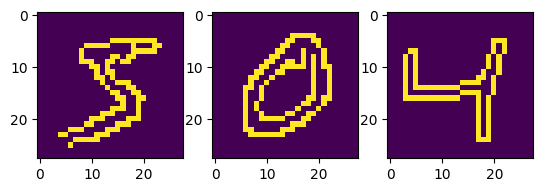

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(Y_train[0])
plt.subplot(1, 3, 2)
plt.imshow(Y_train[1])
plt.subplot(1, 3, 3)
plt.imshow(Y_train[2])
plt.show()

In [ ]:
# CNN 모델 정의: 필터 크기 3x3
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1))
])

# 모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model.compile(optimizer='adam', loss='mean_squared_error')

# 학습 전 커널(필터) 출력
initial_kernel = model.layers[0].get_weights()[0]
print("학습 전 커널(필터) : \n", initial_kernel)

#모델 학습
model.fit(  X_train, Y_train, epochs=100)

# 학습된 커널(필터) 출력
learned_kernel = model.layers[0].get_weights()[0]
print("학습 후 커널(필터) : \n", learned_kernel )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


학습 전 커널(필터) : 
 [[[[-0.20686802]]

  [[ 0.5524441 ]]

  [[ 0.16212815]]]


 [[[ 0.08473134]]

  [[ 0.00797206]]

  [[-0.29835474]]]


 [[[-0.5735639 ]]

  [[-0.18859485]]

  [[-0.53685224]]]]
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7128.0356
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7059.2031 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7041.8457 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6974.2461 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6988.3291 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7057.1050 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7009.1611 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6983.2798 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7051.7139 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6999.8179 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7028.2681 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━

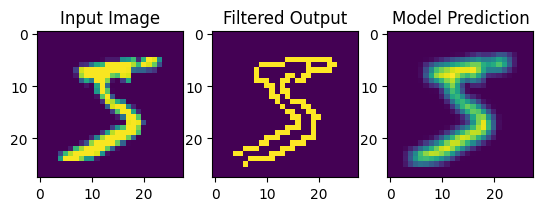

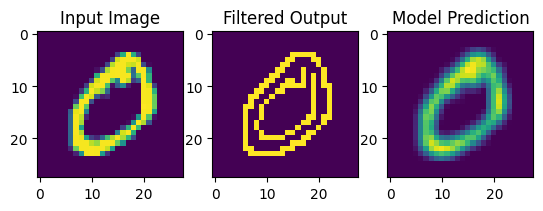

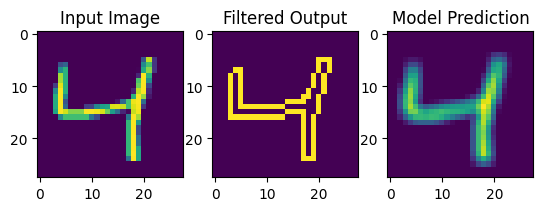

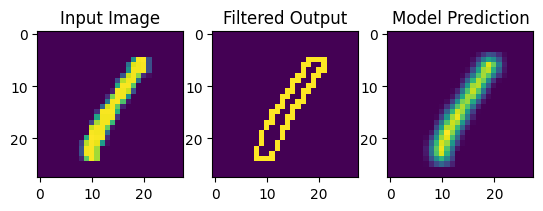

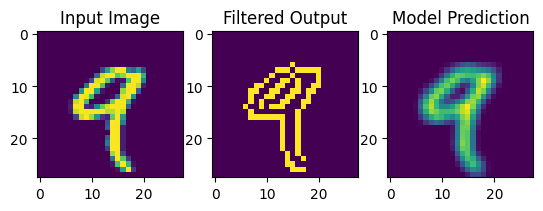

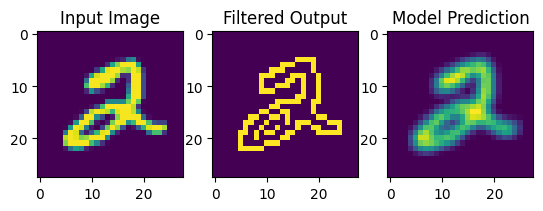

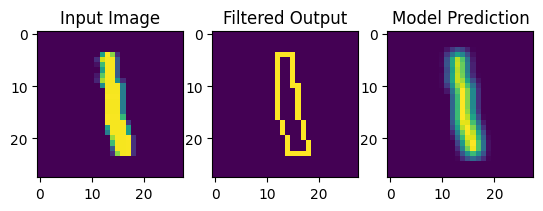

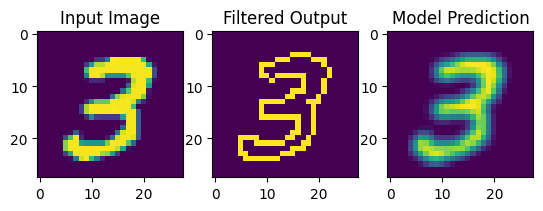

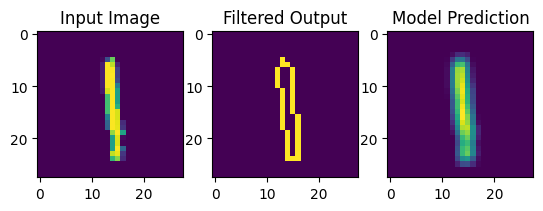

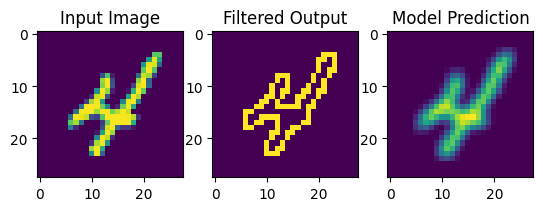

In [ ]:
for idx in range(10):

  # 입력 데이터
  plt.subplot(1, 3, 1)
  plt.imshow(X_train[idx])
  plt.title("Input Image")

  # 필터 적용된 이미지
  plt.subplot(1, 3, 2)
  plt.imshow(Y_train[idx])
  plt.title("Filtered Output")

  # 모델의 예측 결과 (X_train[0]을 모델에 통과시킨 결과)
  predicted_output = model(X_train[idx].reshape((1, 28, 28, 1))).numpy()
  plt.subplot(1, 3, 3)
  plt.imshow(predicted_output.reshape(28, 28))
  plt.title("Model Prediction")
  plt.show()


In [ ]:
# CNN 모델 정의 (깊고 필터 수를 많이 사용)

model_deep = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same')
])

# 모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model_deep.compile(optimizer='adam', loss='mean_squared_error')

#모델 학습
model_deep.fit(  X_train, Y_train, epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 6808.4639
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4808.9971
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4653.7383
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4545.5869
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4432.6650
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4174.9048
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3746.4421
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3076.6179
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2633.0017
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2297.1560
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2046.5874
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1843.2913
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1584.1891
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1422.5939
Epoch 15/100
32/32 ━━━━━━━━━

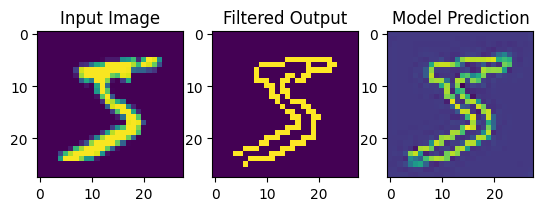

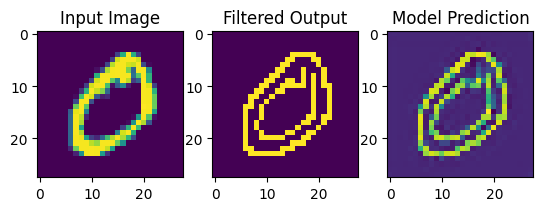

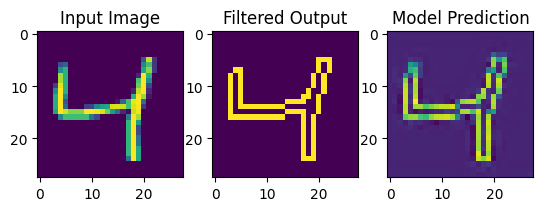

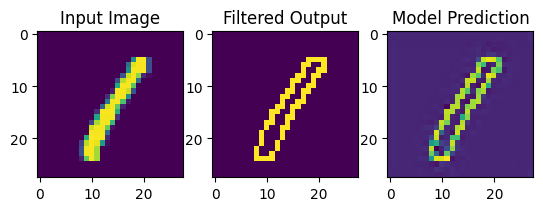

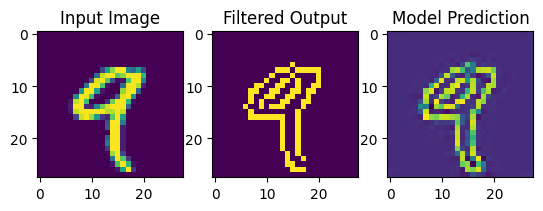

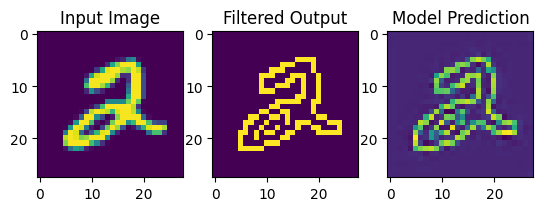

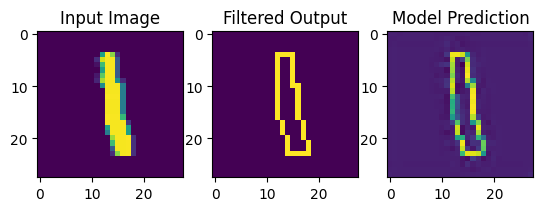

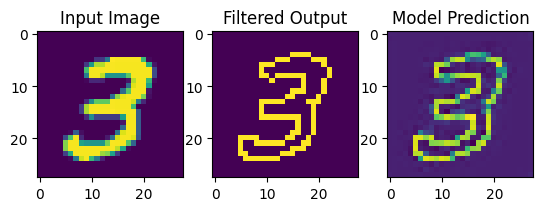

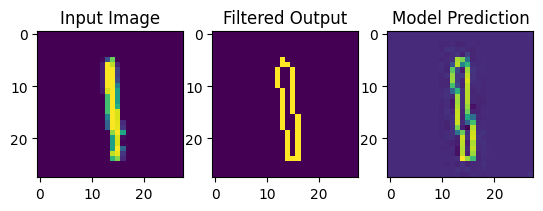

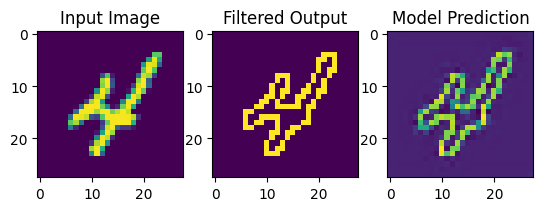

In [ ]:
for idx in range(10):

  # 입력 데이터
  plt.subplot(1, 3, 1)
  plt.imshow(X_train[idx])
  plt.title("Input Image")

  # 필터 적용된 이미지
  plt.subplot(1, 3, 2)
  plt.imshow(Y_train[idx])
  plt.title("Filtered Output")

  # 모델의 예측 결과 (X_train[0]을 모델에 통과시킨 결과)
  predicted_output_deep = model_deep(X_train[idx].reshape((1, 28, 28, 1))).numpy()

  plt.subplot(1, 3, 3)
  plt.imshow(predicted_output_deep.reshape(28, 28))
  plt.title("Model Prediction")
  plt.show()


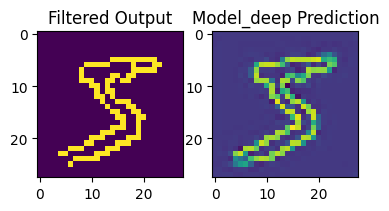

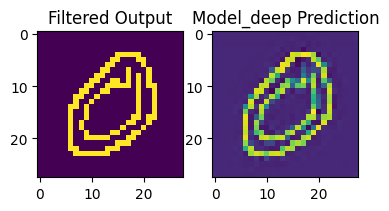

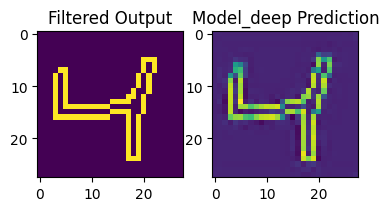

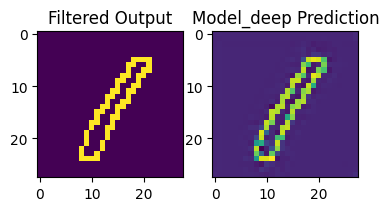

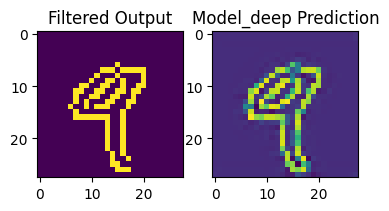

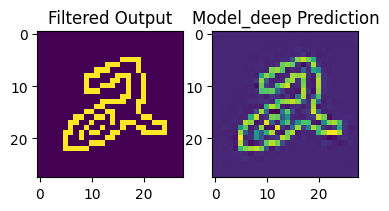

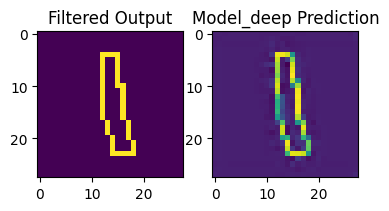

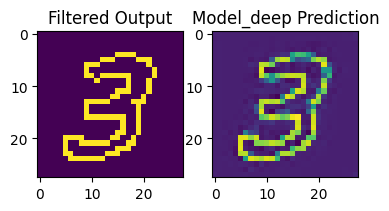

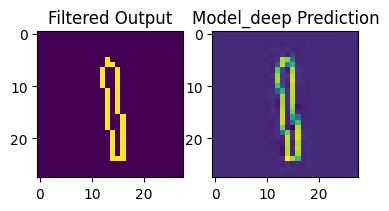

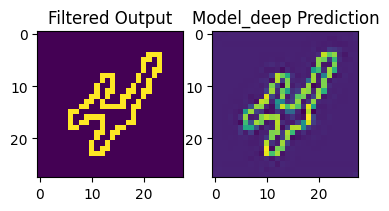

In [ ]:
 for idx in range(10):

  predicted_output = model(X_train[idx].reshape((1, 28, 28, 1))).numpy()
  plt.subplot(1, 3, 3)
  plt.imshow(predicted_output.reshape(28, 28))
  plt.title("Model Prediction")

  # 필터 적용된 이미지
  plt.subplot(1, 3, 2)
  plt.imshow(Y_train[idx])
  plt.title("Filtered Output")

  # 모델의 예측 결과 (X_train[0]을 모델에 통과시킨 결과)

  predicted_output_deep = model_deep(X_train[idx].reshape((1, 28, 28, 1))).numpy()

  plt.subplot(1, 3, 3)
  plt.imshow(predicted_output_deep.reshape(28, 28))
  plt.title("Model_deep Prediction")
  plt.show()

In [ ]:
!jupyter nbconvert --to html Lab_04.ipynb

[NbConvertApp] Converting notebook Lab_04.ipynb to html
[NbConvertApp] Writing 1427134 bytes to Lab_04.html
